# Libreries

In [1]:
import os
import random
import shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import torch
import torch.nn as nn
from torch.optim import SGD, AdamW
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from pytorch_lightning.callbacks import EarlyStopping
import torchvision
from torchsummary import summary

from torchvision import transforms
from torchvision.utils import make_grid

import pytorch_lightning as pl

from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

import warnings

# Disabilita tutti i warning
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Rimuove gli assi dall'immagine
    plt.show()

# Data preprocessing

In [3]:
import os
from PIL import Image
import torchvision.transforms.functional as F

class PadIfNeeded:
    def __init__(self, min_size, padding_mode='constant'):
        self.min_size = min_size
        self.padding_mode = padding_mode

    def __call__(self, img):
        # Calculate padding if needed
        padding_left = max(0, (self.min_size[0] - img.size[0]) // 2)
        padding_right = max(0, self.min_size[0] - img.size[0] - padding_left)
        padding_top = max(0, (self.min_size[1] - img.size[1]) // 2)
        padding_bottom = max(0, self.min_size[1] - img.size[1] - padding_top)
        
        # Apply padding
        img = F.pad(img, (padding_left, padding_top, padding_right, padding_bottom), padding_mode=self.padding_mode)
        return img

def process_and_save_images(input_folder, output_folder, transform):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Iterate through all images in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            # Open the image
            img_path = os.path.join(input_folder, filename)
            image = Image.open(img_path).convert("RGB")
            
            # Apply the transformation
            transformed_image = transform(image)
            
            # Save the transformed image to the output folder
            output_path = os.path.join(output_folder, filename)
            transformed_image.save(output_path)
            print(f"Saved transformed image to {output_path}")

def resize_images(input_folder, output_folder, size=(256, 256)):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Iterate through all images in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            # Open the image
            img_path = os.path.join(input_folder, filename)
            image = Image.open(img_path).convert("RGB")
            
            # Resize the image
            resized_image = image.resize(size)
            
            # Save the resized image to the output folder
            output_path = os.path.join(output_folder, filename)
            resized_image.save(output_path)
            print(f"Saved resized image to {output_path}")


In [4]:
# def verify_images(dataset):
#     images = os.listdir(dataset)
#     for img in images:
#         img_path = os.path.join(dataset, img)
#         try:
#             with Image.open(img_path) as img_file:
#                 img_file.verify()
#         except (IOError, SyntaxError) as e:
#             print(f"Corrupted image file: {img_path}")

# # Use the function
# verify_images("Flickr2K_Padded")

In [5]:
# # Define the padding transformation
# pad_transform = PadIfNeeded(min_size=(2048, 2048))

# # Process the images in the "Flickr2K" folder and save them to a new folder "Flickr2K_Padded"
# process_and_save_images("Flickr2K", "Flickr2K_Padded", pad_transform)

# # Resize the padded images to 256x256 and save them to "Flickr2K_Padded_Resized"
# resize_images("Flickr2K_Padded", "Flickr256_Padded", size=(256, 256))

In [6]:
# resize_images("Flickr256_Padded", "Flickr64_Padded", size=(64, 64))

# Utility functions

In [7]:
def calculate_psnr(image1, image2):
    # Convert images to numpy arrays and scale to [0, 1]
    image1_np = image1.cpu().numpy().transpose(1, 2, 0)
    image2_np = image2.cpu().numpy().transpose(1, 2, 0)
    image1_np = (image1_np - image1_np.min()) / (image1_np.max() - image1_np.min())
    image2_np = (image2_np - image2_np.min()) / (image2_np.max() - image2_np.min())

    return psnr(image1_np, image2_np, data_range=1.0)

def calculate_ssim(image1, image2):
    # Convert images to numpy arrays and scale to [0, 1]
    image1_np = image1.cpu().numpy().transpose(1, 2, 0)
    image2_np = image2.cpu().numpy().transpose(1, 2, 0)
    image1_np = (image1_np - image1_np.min()) / (image1_np.max() - image1_np.min())
    image2_np = (image2_np - image2_np.min()) / (image2_np.max() - image2_np.min())

    return ssim(image1_np, image2_np, data_range=1.0, multichannel=True, win_size=3, channel_axis=-1)

def show_images(model, original_size, scaled_size):
    titles = ['Sr Images', 'Input Images', 'Reconstructed Images']
    image_groups = [model.validation_results['original'],
                    model.validation_results['inputs'],
                    model.validation_results['outputs']]

    Sr_images = model.validation_results['original']
    input_images = model.validation_results['inputs']
    reconstructed_images = model.validation_results['outputs']

    # Calculate PSNR and SSIM
    psnr_reconstructed = np.mean([calculate_psnr(Sr, reconstructed) for Sr, reconstructed in zip(Sr_images, reconstructed_images)])

    ssim_reconstructed = np.mean([calculate_ssim(Sr, reconstructed) for Sr, reconstructed in zip(Sr_images, reconstructed_images)])

    print(f"Average PSNR between Sr and reconstructed images: {psnr_reconstructed:.2f} dB")
    print(f"Average SSIM between Sr and reconstructed images: {ssim_reconstructed:.4f}")

    for images, title in zip(image_groups, titles):
        if title == 'Input Images':
            size = scaled_size
        else:
            size = original_size
        
        images = torchvision.utils.make_grid(images.view(-1, 3, size, size)[:5, ...], nrow=5, normalize=True)
        images_np = images.permute(1, 2, 0).cpu().numpy()

        plt.figure(figsize=(15, 15))
        plt.title(title)
        plt.imshow(images_np)
        plt.axis('off')
        plt.show()

In [8]:
class ImageDataset(Dataset):
    def __init__(self, dataset_sr_dir, dataset_lr_dir, transform_original=None, transform_rescaled=None):
        self.dataset_sr_dir = dataset_sr_dir
        self.dataset_lr_dir = dataset_lr_dir
        
        self.transform_original = transform_original
        self.transform_rescaled = transform_rescaled
        
        self.images_sr = os.listdir(dataset_sr_dir)
        self.images_lr = os.listdir(dataset_lr_dir)
        
    def __len__(self):
        return len(self.images_sr)

    def __getitem__(self, idx):
        img_sr_path = os.path.join(self.dataset_sr_dir, self.images_sr[idx])
        img_lr_path = os.path.join(self.dataset_lr_dir, self.images_lr[idx])
        
        try:
            original_image = Image.open(img_sr_path).convert("RGB")
            rescaled_image = Image.open(img_lr_path).convert("RGB")
            
        except OSError:
            print(f"Skipping corrupted image: {img_sr_path}")
            return self.__getitem__((idx + 1) % len(self.images))
        
        if self.transform_original:
            original_image = self.transform_original(original_image)
        
        if self.transform_rescaled:
            rescaled_image = self.transform_rescaled(rescaled_image)

        return rescaled_image, original_image

# Experiments

## Data loader

In [9]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Imposta il seed per rendere l'esperimento ripetibile
seed = 42
set_seed(seed)

original_size = 256

scaled_size = 64

dataset_sr_dir = "Flickr256_Padded"

dataset_lr_dir = "Flickr64_Padded"

# Creazione del dataset
dataset = ImageDataset(dataset_sr_dir,
                       dataset_lr_dir,
                       transform_original=transforms.Compose([
                            transforms.ToTensor()
                        ]),
                       transform_rescaled=transforms.Compose([
                            transforms.ToTensor()
                        ]))

# Suddivisione del dataset in train e validation set (80% train, 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

# Creazione dei dataloader per train e val
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Experiment 1

In [10]:
class SrConvAutoencoder(pl.LightningModule):
    def __init__(self):
        self.validation_results = {
            'original': [],
            'inputs': [],
            'outputs': []
        }
        self.train_step_losses = []
        self.val_step_losses = []
        self.train_losses = []
        self.val_losses = []

        super(SrConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1),
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return code, reconstructed

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr = 1e-4, weight_decay=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_lr, x_original = train_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_step_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        self.train_losses.append(self.train_step_losses[-1])

    def validation_step(self, val_batch, batch_idx):
        x_lr, x_original = val_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('val/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_losses.append(loss.item())

        self.validation_results['original'] = x_original
        self.validation_results['inputs'] = x_lr 
        self.validation_results['outputs'] = reconstructed

        return loss

    def on_train_end(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        torch.save(self.state_dict(), 'models/denoising_conv_autoencoder_v1.pth')

    def on_validation_epoch_end(self):
        self.val_losses.append(min(self.val_step_losses))
        
    def on_train_start(self):
        print()
        # Assicurati che il modello sia sulla CPU per il summary
        if torch.cuda.is_available():
            self.cuda()
        summary(self, (3, 128, 128))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder   | Sequential | 6.0 K 
1 | decoder   | Sequential | 6.0 K 
2 | criterion | MSELoss    | 0     
-----------------------------------------
12.0 K    Trainable params
0         Non-trainable params
12.0 K    Total params
0.048     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]                                
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
              SiLU-2          [-1, 8, 128, 128]               0
            Conv2d-3         [-1, 16, 128, 128]           1,168
              SiLU-4         [-1, 16, 128, 128]               0
         AvgPool2d-5           [-1, 16, 64, 64]               0
            Conv2d-6           [-1, 32, 64, 64]           4,640
              SiLU-7           [-1, 32, 64, 64]               0
   ConvTranspose2d-8         [-1, 16, 128, 128]           4,624
              SiLU-9         [-1, 16, 128, 128]               0
  ConvTranspose2d-10          [-1, 8, 256, 256]           1,160
             SiLU-11          [-1, 8, 256, 256]               0
  ConvTranspose2d-12          [-1, 3, 512, 512]             219
Total params: 12,035
Traina

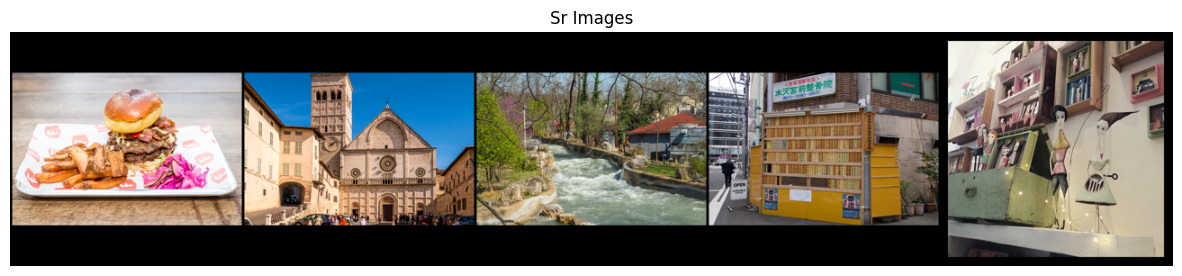

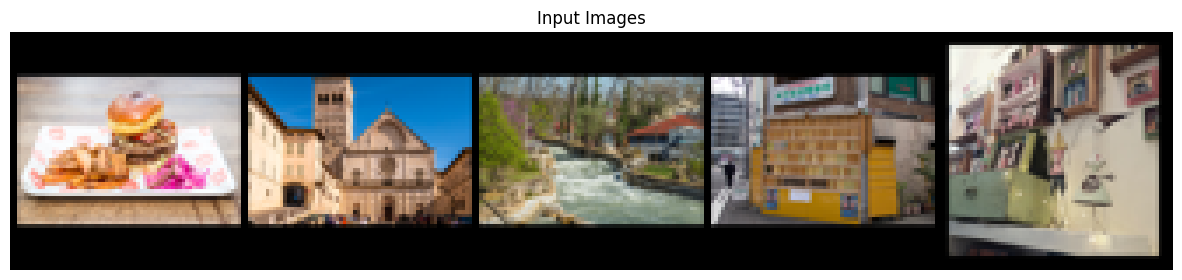

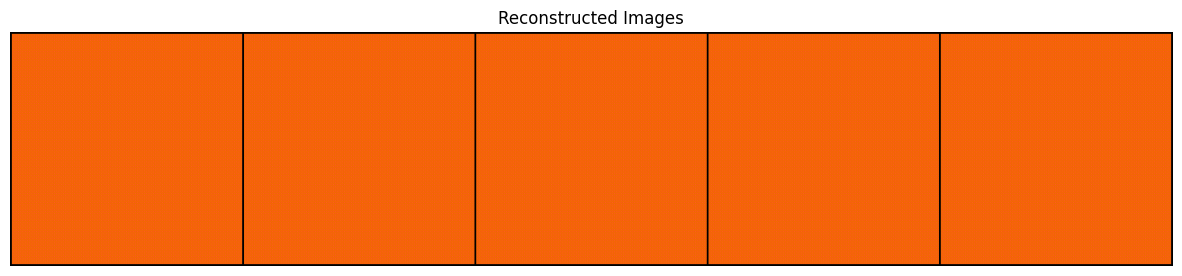

In [11]:
autoencoder = SrConvAutoencoder()

early_stopping = EarlyStopping(
    monitor='val/loss',  # Metrius per monitorare
    patience=10,  # Numero di epoch senza miglioramenti dopo i quali fermare il training
    verbose=True,
    mode='min',  # 'min' per fermare quando la metrica smette di diminuire, 'max' per fermare quando smette di aumentare,
    min_delta=0.005
)

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stopping]
)

trainer.fit(autoencoder, train_dataloader, val_dataloader)

show_images(autoencoder,original_size,scaled_size)

# Experiment 2

In [ ]:
class SrConvAutoencoder(pl.LightningModule):
    def __init__(self):
        self.validation_results = {
            'original': [],
            'inputs': [],
            'outputs': []
        }
        self.train_step_losses = []
        self.val_step_losses = []
        self.train_losses = []
        self.val_losses = []

        super(SrConvAutoencoder, self).__init__()
        # Encoder

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.SiLU(),
            nn.Conv2d(8, 3, kernel_size=3, stride=1, padding=1),
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return code, reconstructed

    def configure_optimizers(self):
        # optimizer = SGD(self.parameters(), lr=0.01, momentum=0.99)
        optimizer = AdamW(self.parameters(), lr = 1e-4, weight_decay=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_lr, x_original = train_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_step_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        self.train_losses.append(self.train_step_losses[-1])

    def validation_step(self, val_batch, batch_idx):
        x_lr, x_original = val_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('val/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_losses.append(loss.item())

        self.validation_results['original'] = x_original
        self.validation_results['inputs'] = x_lr 
        self.validation_results['outputs'] = reconstructed

        return loss

    def on_train_end(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        torch.save(self.state_dict(), 'models/denoising_conv_autoencoder_v2.pth')

    def on_validation_epoch_end(self):
        self.val_losses.append(min(self.val_step_losses))
    
    def on_train_start(self):
        print()
        # Assicurati che il modello sia sulla CPU per il summary
        if torch.cuda.is_available():
            self.cuda()
        summary(self, (3, 128, 128))

In [ ]:
autoencoder = SrConvAutoencoder()

early_stopping = EarlyStopping(
    monitor='val/loss',  # Metrius per monitorare
    patience=10,  # Numero di epoch senza miglioramenti dopo i quali fermare il training
    verbose=True,
    mode='min',  # 'min' per fermare quando la metrica smette di diminuire, 'max' per fermare quando smette di aumentare,
    min_delta=0.005
)

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stopping]
)

trainer.fit(autoencoder, train_dataloader, val_dataloader)

show_images(autoencoder,original_size,scaled_size)

# Experiment 3

In [ ]:
class SrConvAutoencoder(pl.LightningModule):
    def __init__(self):
        self.validation_results = {
            'original': [],
            'inputs': [],
            'outputs': []
        }
        self.train_step_losses = []
        self.val_step_losses = []
        self.train_losses = []
        self.val_losses = []

        super(SrConvAutoencoder, self).__init__()
        # Encoder

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.SiLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.SiLU(),
            nn.Conv2d(8, 3, kernel_size=3, stride=1, padding=1),
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return code, reconstructed

    def configure_optimizers(self):
        # optimizer = SGD(self.parameters(), lr=0.01, momentum=0.99)
        optimizer = AdamW(self.parameters(), lr = 1e-4, weight_decay=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_lr, x_original = train_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_step_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        self.train_losses.append(self.train_step_losses[-1])

    def validation_step(self, val_batch, batch_idx):
        x_lr, x_original = val_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('val/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_losses.append(loss.item())

        self.validation_results['original'] = x_original
        self.validation_results['inputs'] = x_lr
        self.validation_results['outputs'] = reconstructed

        return loss

    def on_train_end(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        torch.save(self.state_dict(), 'models/denoising_conv_autoencoder_v3.pth')

    def on_validation_epoch_end(self):
        self.val_losses.append(min(self.val_step_losses))
        
    def on_train_start(self):
        print()
        # Assicurati che il modello sia sulla CPU per il summary
        if torch.cuda.is_available():
            self.cuda()
        summary(self, (3, 128, 128))

In [ ]:
autoencoder = SrConvAutoencoder()

early_stopping = EarlyStopping(
    monitor='val/loss',  # Metrius per monitorare
    patience=10,  # Numero di epoch senza miglioramenti dopo i quali fermare il training
    verbose=True,
    mode='min',  # 'min' per fermare quando la metrica smette di diminuire, 'max' per fermare quando smette di aumentare,
    min_delta=0.005
)

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stopping]
)

trainer.fit(autoencoder, train_dataloader, val_dataloader)

show_images(autoencoder,original_size,scaled_size)

## Experiment 4

In [ ]:
class SrConvAutoencoder(pl.LightningModule):
    def __init__(self):
        self.validation_results = {
            'original': [],
            'inputs': [],
            'outputs': []
        }
        self.train_step_losses = []
        self.val_step_losses = []
        self.train_losses = []
        self.val_losses = []

        super(SrConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),  # 32x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        self.criterion = nn.MSELoss()

    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return code, reconstructed

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-4, weight_decay=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_lr, x_original = train_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_step_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        self.train_losses.append(self.train_step_losses[-1])

    def validation_step(self, val_batch, batch_idx):
        x_lr, x_original = val_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('val/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_losses.append(loss.item())

        self.validation_results['original'] = x_original
        self.validation_results['inputs'] = x_lr
        self.validation_results['outputs'] = reconstructed

        return loss

    def on_train_end(self):
        plt.figure(figoriginal_original_original_original_original_original_original_size=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        torch.save(self.state_dict(), 'models/denoising_conv_autoencoder_v4.pth')

    def on_validation_epoch_end(self):
        self.val_losses.append(min(self.val_step_losses))
        
    def on_train_start(self):
        print()
        # Assicurati che il modello sia sulla CPU per il summary
        if torch.cuda.is_available():
            self.cuda()
        summary(self, (3, 128, 128))

In [ ]:
autoencoder = SrConvAutoencoder()

early_stopping = EarlyStopping(
    monitor='val/loss',  # Metrius per monitorare
    patience=10,  # Numero di epoch senza miglioramenti dopo i quali fermare il training
    verbose=True,
    mode='min',  # 'min' per fermare quando la metrica smette di diminuire, 'max' per fermare quando smette di aumentare,
    min_delta=0.005
)

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stopping]
)

trainer.fit(autoencoder, train_dataloader, val_dataloader)

show_images(autoencoder,original_size, scaled_size)

## Experiment 5

In [ ]:
class SrConvAutoencoder(pl.LightningModule):
    def __init__(self):
        self.validation_results = {
            'original': [],
            'inputs': [],
            'outputs': []
        }
        self.train_step_losses = []
        self.val_step_losses = []
        self.train_losses = []
        self.val_losses = []

        super(SrConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),  # 32x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        self.criterion = nn.MSELoss()

    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return code, reconstructed

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-4, weight_decay=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_lr, x_original = train_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_step_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        self.train_losses.append(self.train_step_losses[-1])

    def validation_step(self, val_batch, batch_idx):
        x_lr, x_original = val_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('val/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_losses.append(loss.item())

        self.validation_results['original'] = x_original
        self.validation_results['inptus'] = x_lr
        self.validation_results['outputs'] = reconstructed

        return loss

    def on_train_end(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        torch.save(self.state_dict(), 'models/denoising_conv_autoencoder_v5.pth')

    def on_validation_epoch_end(self):
        self.val_losses.append(min(self.val_step_losses))
        
    def on_train_start(self):
        print()
        # Assicurati che il modello sia sulla CPU per il summary
        if torch.cuda.is_available():
            self.cuda()
        summary(self, (3, 128, 128))

In [ ]:
autoencoder = SrConvAutoencoder()

early_stopping = EarlyStopping(
    monitor='val/loss',  # Metrius per monitorare
    patience=10,  # Numero di epoch senza miglioramenti dopo i quali fermare il training
    verbose=True,
    mode='min',  # 'min' per fermare quando la metrica smette di diminuire, 'max' per fermare quando smette di aumentare,
    min_delta=0.005
)

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stopping]
)

trainer.fit(autoencoder, train_dataloader, val_dataloader)

show_images(autoencoder,original_size,scaled_size)

## Experiment 6

In [ ]:
class SrConvAutoencoder(pl.LightningModule):
    def __init__(self):
        self.validation_results = {
            'original': [],
            'inputs': [],
            'outputs': []
        }
        self.train_step_losses = []
        self.val_step_losses = []
        self.train_losses = []
        self.val_losses = []

        super(SrConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),  # 32x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        self.criterion = nn.MSELoss()

    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return code, reconstructed

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-4, weight_decay=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_lr, x_original = train_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_step_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        self.train_losses.append(self.train_step_losses[-1])

    def validation_step(self, val_batch, batch_idx):
        x_lr, x_original = val_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('val/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_losses.append(loss.item())

        self.validation_results['original'] = x_original
        self.validation_results['inputs'] = x_lr
        self.validation_results['outputs'] = reconstructed

        return loss

    def on_train_end(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        torch.save(self.state_dict(), 'models/denoising_conv_autoencoder_v6.pth')

    def on_validation_epoch_end(self):
        self.val_losses.append(min(self.val_step_losses))
        
    def on_train_start(self):
        print()
        # Assicurati che il modello sia sulla CPU per il summary
        if torch.cuda.is_available():
            self.cuda()
        summary(self, (3, 128, 128))

In [ ]:
autoencoder = SrConvAutoencoder()

early_stopping = EarlyStopping(
    monitor='val/loss',  # Metrius per monitorare
    patience=10,  # Numero di epoch senza miglioramenti dopo i quali fermare il training
    verbose=True,
    mode='min',  # 'min' per fermare quando la metrica smette di diminuire, 'max' per fermare quando smette di aumentare,
    min_delta=0.005
)

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stopping]
)

trainer.fit(autoencoder, train_dataloader, val_dataloader)

show_images(autoencoder,original_size,scaled_size)

## Experiment 7

In [ ]:
class SrConvAutoencoder(pl.LightningModule):
    def __init__(self):
        self.validation_results = {
            'original': [],
            'inputs': [],
            'outputs': []
        }
        self.train_step_losses = []
        self.val_step_losses = []
        self.train_losses = []
        self.val_losses = []

        super(SrConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),  # 32x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),  # 16x16
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        self.criterion = nn.MSELoss()

    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return code, reconstructed

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-4, weight_decay=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_lr, x_original = train_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_step_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        self.train_losses.append(self.train_step_losses[-1])

    def validation_step(self, val_batch, batch_idx):
        x_lr, x_original = val_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('val/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_losses.append(loss.item())

        self.validation_results['original'] = x_original
        self.validation_results['inputs'] = x_lr
        self.validation_results['outputs'] = reconstructed

        return loss

    def on_train_end(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        torch.save(self.state_dict(), 'models/denoising_conv_autoencoder_v7.pth')

    def on_validation_epoch_end(self):
        self.val_losses.append(min(self.val_step_losses))
        
    def on_train_start(self):
        print()
        # Assicurati che il modello sia sulla CPU per il summary
        if torch.cuda.is_available():
            self.cuda()
        summary(self, (3, 128, 128))

In [ ]:
autoencoder = SrConvAutoencoder()

early_stopping = EarlyStopping(
    monitor='val/loss',  # Metrius per monitorare
    patience=10,  # Numero di epoch senza miglioramenti dopo i quali fermare il training
    verbose=True,
    mode='min',  # 'min' per fermare quando la metrica smette di diminuire, 'max' per fermare quando smette di aumentare,
    min_delta=0.005
)

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stopping]
)

trainer.fit(autoencoder, train_dataloader, val_dataloader)

show_images(autoencoder,original_size,scaled_size)

## Experiment 8

In [ ]:
class SrConvAutoencoder(pl.LightningModule):
    def __init__(self):
        self.validation_results = {
            'original': [],
            'inputs': [],
            'outputs': []
        }
        self.train_step_losses = []
        self.val_step_losses = []
        self.train_losses = []
        self.val_losses = []

        super(SrConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),  # 32x32

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),  # 16x16
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        self.criterion = nn.MSELoss()

    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return code, reconstructed

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-4, weight_decay=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_lr, x_original = train_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_step_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        self.train_losses.append(self.train_step_losses[-1])

    def validation_step(self, val_batch, batch_idx):
        x_lr, x_original = val_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('val/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_losses.append(loss.item())

        self.validation_results['original'] = x_original
        self.validation_results['input'] = x_lr
        self.validation_results['outputs'] = reconstructed

        return loss

    def on_train_end(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        torch.save(self.state_dict(), 'models/denoising_conv_autoencoder_v8.pth')

    def on_validation_epoch_end(self):
        self.val_losses.append(min(self.val_step_losses))
        
    def on_train_start(self):
        print()
        # Assicurati che il modello sia sulla CPU per il summary
        if torch.cuda.is_available():
            self.cuda()
        summary(self, (3, 128, 128))

In [ ]:
autoencoder = SrConvAutoencoder()

early_stopping = EarlyStopping(
    monitor='val/loss',  # Metrius per monitorare
    patience=10,  # Numero di epoch senza miglioramenti dopo i quali fermare il training
    verbose=True,
    mode='min',  # 'min' per fermare quando la metrica smette di diminuire, 'max' per fermare quando smette di aumentare,
    min_delta=0.005
)

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stopping]
)

trainer.fit(autoencoder, train_dataloader, val_dataloader)

show_images(autoencoder,original_size,scaled_size)

## Experiment 9

In [ ]:
class SrConvAutoencoder(pl.LightningModule):
    def __init__(self):
        self.validation_results = {
            'original': [],
            'inputs': [],
            'outputs': []
        }
        self.train_step_losses = []
        self.val_step_losses = []
        self.train_losses = []
        self.val_losses = []

        super(SrConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=4),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),  # 64x64

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),  # 32x32
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=3),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 3, kernel_size=7, stride=1, padding=2),
            nn.Tanh()
        )

        self.criterion = nn.MSELoss()

    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return code, reconstructed

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-4, weight_decay=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_lr, x_original = train_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_step_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        self.train_losses.append(self.train_step_losses[-1])

    def validation_step(self, val_batch, batch_idx):
        x_lr, x_original = val_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('val/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_losses.append(loss.item())

        self.validation_results['original'] = x_original
        self.validation_results['inputs'] = x_lr
        self.validation_results['outputs'] = reconstructed

        return loss

    def on_train_end(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        torch.save(self.state_dict(), 'models/denoising_conv_autoencoder_v9.pth')

    def on_validation_epoch_end(self):
        self.val_losses.append(min(self.val_step_losses))
        
    def on_train_start(self):
        print()
        # Assicurati che il modello sia sulla CPU per il summary
        if torch.cuda.is_available():
            self.cuda()
        summary(self, (3, 128, 128))

In [ ]:
autoencoder = SrConvAutoencoder()

early_stopping = EarlyStopping(
    monitor='val/loss',  # Metrius per monitorare
    patience=10,  # Numero di epoch senza miglioramenti dopo i quali fermare il training
    verbose=True,
    mode='min',  # 'min' per fermare quando la metrica smette di diminuire, 'max' per fermare quando smette di aumentare,
    min_delta=0.005
)

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stopping]
)

trainer.fit(autoencoder, train_dataloader, val_dataloader)

show_images(autoencoder,original_size,scaled_size)

## Experiment 10

In [ ]:
class SrConvAutoencoder(pl.LightningModule):
    def __init__(self):
        self.validation_results = {
            'original': [],
            'inputs': [],
            'outputs': []
        }
        self.train_step_losses = []
        self.val_step_losses = []
        self.train_losses = []
        self.val_losses = []

        super(SrConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),  # 64x64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=3),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 3, kernel_size=7, stride=1, padding=2),
            nn.Tanh()
        )

        self.criterion = nn.MSELoss()

    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return code, reconstructed

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-4, weight_decay=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_lr, x_original = train_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_step_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        self.train_losses.append(self.train_step_losses[-1])

    def validation_step(self, val_batch, batch_idx):
        x_lr, x_original = val_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('val/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_losses.append(loss.item())

        self.validation_results['original'] = x_original
        self.validation_results['inputs'] = x_lr
        self.validation_results['outputs'] = reconstructed

        return loss

    def on_train_end(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        torch.save(self.state_dict(), 'models/denoising_conv_autoencoder_v10.pth')

    def on_validation_epoch_end(self):
        self.val_losses.append(min(self.val_step_losses))
        
    def on_train_start(self):
        print()
        # Assicurati che il modello sia sulla CPU per il summary
        if torch.cuda.is_available():
            self.cuda()
        summary(self, (3, 128, 128))

In [ ]:
autoencoder = SrConvAutoencoder()

early_stopping = EarlyStopping(
    monitor='val/loss',  # Metrius per monitorare
    patience=10,  # Numero di epoch senza miglioramenti dopo i quali fermare il training
    verbose=True,
    mode='min',  # 'min' per fermare quando la metrica smette di diminuire, 'max' per fermare quando smette di aumentare,
    min_delta=0.005
)

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stopping]
)

trainer.fit(autoencoder, train_dataloader, val_dataloader)

show_images(autoencoder,original_size,scaled_size)

## Experiment 11

In [ ]:
class SrConvAutoencoder(pl.LightningModule):
    def __init__(self):
        self.validation_results = {
            'original': [],
            'inputs': [],
            'outputs': []
        }
        self.train_step_losses = []
        self.val_step_losses = []
        self.train_losses = []
        self.val_losses = []

        super(SrConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),  # 64x64
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=3),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 3, kernel_size=7, stride=1, padding=2),
            nn.Tanh()
        )

        self.criterion = nn.MSELoss()

    def forward(self, x):
        code = self.encoder(x)
        reconstructed = self.decoder(code)
        return code, reconstructed

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=1e-4, weight_decay=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_lr, x_original = train_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_step_losses.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        self.train_losses.append(self.train_step_losses[-1])

    def validation_step(self, val_batch, batch_idx):
        x_lr, x_original = val_batch
        _, reconstructed = self.forward(x_lr)
        loss = self.criterion(x_original, reconstructed)
        self.log('val/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.val_step_losses.append(loss.item())

        self.validation_results['original'] = x_original
        self.validation_results['inputs'] = x_lr
        self.validation_results['outputs'] = reconstructed

        return loss

    def on_train_end(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        torch.save(self.state_dict(), 'models/denoising_conv_autoencoder_v11.pth')

    def on_validation_epoch_end(self):
        self.val_losses.append(min(self.val_step_losses))
        
    def on_train_start(self):
        print()
        # Assicurati che il modello sia sulla CPU per il summary
        if torch.cuda.is_available():
            self.cuda()
        summary(self, (3, 128, 128))

In [ ]:
autoencoder = SrConvAutoencoder()

early_stopping = EarlyStopping(
    monitor='val/loss',  # Metrius per monitorare
    patience=10,  # Numero di epoch senza miglioramenti dopo i quali fermare il training
    verbose=True,
    mode='min',  # 'min' per fermare quando la metrica smette di diminuire, 'max' per fermare quando smette di aumentare,
    min_delta=0.005
)

trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stopping]
)

trainer.fit(autoencoder, train_dataloader, val_dataloader)

show_images(autoencoder,original_size,scaled_size)